In [1]:
import numpy as np
import sympy
from sympy import Expr, Eq, latex, plot_implicit, tan, cot
from sympy.core import S, pi, sympify
from sympy.core.logic import fuzzy_bool
from sympy.core.numbers import Rational, oo
from sympy.core.compatibility import ordered
from sympy.core.symbol import Dummy, _uniquely_named_symbol, _symbol
from sympy.simplify import simplify, trigsimp
from sympy.functions.elementary.miscellaneous import sqrt, Max
from sympy.functions.elementary.trigonometric import cos, sin
from sympy.functions.special.elliptic_integrals import elliptic_e
from sympy.geometry.exceptions import GeometryError
from sympy.geometry.line import Ray2D, Segment2D, Line2D, LinearEntity3D
from sympy.polys import DomainError, Poly, PolynomialError
from sympy.polys.polyutils import _not_a_coeff, _nsort
from sympy.solvers import solve
from sympy.solvers.solveset import linear_coeffs
from sympy.utilities.misc import filldedent, func_name
from sympy.geometry.entity import GeometryEntity, GeometrySet
from sympy.geometry.point import Point, Point2D, Point3D
from sympy.geometry.line import Line, Segment
from sympy.geometry.util import idiff
import matplotlib.pyplot as plt
from IPython.display import Math, Latex

# Практическое занятие 15
# Компьютерный практикум по алгебре на Python
## Кривые второго порядка на плоскости: гипербола

In [2]:
class Hyperbola(GeometrySet):
    """
     Attributes
    ==========
    center
    hradius
    vradius
    eccentricity
    periapsis
    focus_distance
    foci
    ==========
    конструктор __new__
    скопирован из Эллипса,
    изменена формула для  hradius и vradius через эсцентриситет
    """
    def __new__(
        cls, center=None, hradius=None, vradius=None, eccentricity=None, **kwargs):
        hradius = sympify(hradius)
        vradius = sympify(vradius)

        eccentricity = sympify(eccentricity)

        if center is None:
            center = Point(0, 0)
        else:
            center = Point(center, dim=2)

        if len(center) != 2:
            raise ValueError('The center of "{0}" must be a two dimensional point'.format(cls))

        if len(list(filter(lambda x: x is not None, (hradius, vradius, eccentricity)))) != 2:
            raise ValueError(filldedent('''
                Exactly two arguments of "hradius", "vradius", and
                "eccentricity" must not be None.'''))

        if eccentricity is not None:
            if hradius is None:
                hradius = vradius/sqrt( eccentricity**2 - 1)
            elif vradius is None:
                vradius = hradius*sqrt( eccentricity**2 - 1)

        if hradius == 0:
            return "Line"
        if vradius == 0:
            return "Rays"
        return GeometryEntity.__new__(cls, center, hradius, vradius, **kwargs)
    
    @property
    def ambient_dimension(self):
        return 2
    
    @property
    def center(self):
        return self.args[0]

    @property
    def hradius(self):
        return self.args[1]
    
    @property
    def vradius(self):
        return self.args[2]
    @property
    def focus_distance(self):
        return sqrt(self.hradius**2 + self.vradius**2)
    
    @property
    def eccentricity(self):
        """The eccentricity of the ellipse."""
        return self.focus_distance/self.hradius
    
    @property
    def periapsis(self):
        """The apoapsis of the hyperbola.
        The smallest distance between the focus and the contour."""
        return self.focus_distance-self.hradius
    @property
    def foci(self):
        return (self.center + Point(-self.focus_distance, 0), self.center + Point(self.focus_distance, 0))
    
    @property
    def major(self):
        return self.hradius
    
    @property
    def minor(self):
        return self.vradius

    def asymptote(self, x='x', y='y', equation=False, tg_a = 0):
      x = _symbol(x, real=True)
      y = _symbol(y, real=True)
      x0 = self.center[0]
      y0 = self.center[1]
      a = self.hradius
      b = self.vradius

      if tg_a == 0:
        if not equation:
          return (y0 + (x - x0) * b / a, y0 - (x - x0) * b / a)
        else:
          return (Eq(y, y0 + (x - x0) * b / a), 
                  Eq(y, y0 - (x - x0) * b / a))
      else:
        k1 = (b + a * tg_a) / (a - b * tg_a)
        k2 = (-b + a * tg_a) / (a + b * tg_a)
        if not equation:
          return y0 + k1 * (x - x0), y0 + k2 * (x - x0)
        else:
          return Eq(y, y0 + k1 * (x - x0)), Eq(y, y0 + k2 * (x - x0))

    def directrix(self, x='x', y='y', equation=False, tg_a = 0):
      x = _symbol(x, real=True)
      y = _symbol(y, real=True)
      x0 = self.center[0]
      y0 = self.center[1]
      a = self.hradius
      c = self.focus_distance

      if tg_a == 0:
        if not equation:
          return (x0 + a ** 2 / c, x0 - a ** 2 / c)
        else:
          return (Eq(x, x0 + a ** 2 / c), 
                  Eq(x, x0 - a ** 2 / c))
      else:
        if not equation:
          return (y0 - 1 / tg_a * (x - x0) + a ** 2 * (1 + 1 / tg_a) ** S.Half / c,
                  y0 - 1 / tg_a * (x - x0) - a ** 2 * (1 + 1 / tg_a) ** S.Half / c)
        else:
          return (Eq(y, y0 - 1 / tg_a * (x - x0) + a ** 2 * (1 + 1 / tg_a) ** S.Half / c), 
                  Eq(y, y0 - 1 / tg_a * (x - x0) - a ** 2 * (1 + 1 / tg_a) ** S.Half / c))
    
    def equation(self, x='x', y='y', _slope=None, equation=False):
        """
        Returns the equation of a hyperbola aligned with the x and y axes;
        when slope is given, the equation returned corresponds to a hyperbola 
        with a major axis having that slope.
        Parameters
        ==========
        x : str, optional
            Label for the x-axis. Default value is 'x'.
        y : str, optional
            Label for the y-axis. Default value is 'y'.
        _slope : Expr, optional
                The slope of the major axis. Ignored when 'None'.
        Returns
        =======
        equation : sympy expression   """

        x = _symbol(x, real=True)
        y = _symbol(y, real=True)

        dx = x - self.center.x
        dy = y - self.center.y

        if _slope is not None:
            L = (dy - _slope*dx)**2
            l = (_slope*dy + dx)**2
            h = 1 + _slope**2
            a = h*self.major**2
            b = h*self.minor**2
            res = l/a - L/b 

        else:
            t1 = (dx/self.hradius)**2
            t2 = (dy/self.vradius)**2
            res = t1 - t2 
        if not equation:
            return res - 1
        else:
            return Eq(res, 1)

# Занятие 15
# Алгебра
### Задание 1.
Построить гиперболу с центром в точке А(1, 2), полуосями 12 и 5. Вывести на экран эксцентриситет, фокусное расстояние, фокусы (с координатами), periapsis и уравнение гиперболы.

In [3]:
Hyp1 = Hyperbola(Point(1, 2), hradius=12, vradius=5)
Hyp1

Hyperbola(Point2D(1, 2), 12, 5)

In [4]:
print("Эксцентриситет:")
display(Hyp1.eccentricity)
print()
print("Фокусное расстояние:")
display(Hyp1.focus_distance)
print()
print("Фокусы:")
display(*Hyp1.foci)
print()
print("Periapsis:")
display(Hyp1.periapsis)
print()
print("Уравнение гиперболы:")
display(Hyp1.equation())

Эксцентриситет:


13/12


Фокусное расстояние:


13


Фокусы:


Point2D(-12, 2)

Point2D(14, 2)


Periapsis:


1


Уравнение гиперболы:


(x/12 - 1/12)**2 - (y/5 - 2/5)**2 - 1

### Задание 2.
Добавить в описание класса гипербол методы 

asymptote(self, x='x', y='y', equation=False)

directrix(self, x='x', equation=False)

Для гиперболы Задания 1 вывести на экран уравнения асимптот и директрис.

In [5]:
display('асимптоты', *(Hyp1.asymptote(equation=True)))
print()
display('директрисы', *(Hyp1.directrix(equation=True)))

'асимптоты'

Eq(y, 5*x/12 + 19/12)

Eq(y, 29/12 - 5*x/12)

'директрисы'

Eq(x, 157/13)

Eq(x, -131/13)

### Задание 3.
Вывести на экран уравнение гиперболы из задания 1 с поворотом на 30 градусов против часовой стрелки относительно ее центра.
Изобразить повернутую гиперболу с помощью plot_implicit.

In [6]:
Hyp3 = Hyp1.equation(_slope=sympy.sqrt(3)/3, equation=True)
Hyp3

Eq((x + sqrt(3)*(y - 2)/3 - 1)**2/192 - 3*(y - sqrt(3)*(x - 1)/3 - 2)**2/100, 1)

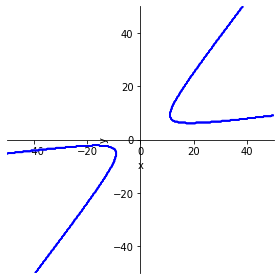

In [7]:
eq = Hyp3
dict_free = {str(a): a for a in eq.free_symbols}
p = plot_implicit(eq, (dict_free['x'], -50, 50), (dict_free['y'], -50, 50),
                  line_color='b', aspect_ratio=(1, 1), show=False, adaptive=False)
p.show()

## Уравнения директрис и асимптот при повороте на угол $\alpha$
Пусть  $a$ - горизонтальная полуось, $c$ - фокусное расстояние, $x_0$ - горизонтальная координата центра гиперболы, тогда уравнение директрис 
$$
x = x_0 \pm \frac{a^2}{c}
$$
При повороте на угол $\alpha$ получается уравнение
$$
y = y_0 -{\rm ctg} \alpha(x - x_0) \pm \frac{a^2}{c}\sqrt{1 + {\rm ctg} \alpha}
$$
Уравнение асимптоты
$$
y = y_0 \pm \frac{b}{a}(x - x_0)
$$
При повороте на угол $\alpha$ получаются уравнения
\begin{align*}
y_1 = y_0 + k_1(x - x_0), \quad 
y_2 = y_0 + k_2(x - x_0), \\ 
k_1 = \frac{b + a{\rm tg} \alpha}{a - b{\rm tg} \alpha},\quad 
k_2 = \frac{-b + a{\rm tg} \alpha}{a + b{\rm tg} \alpha}
\end{align*}
### Задание 4.
Изобразить гиперболу Задания 3 (т.е. повернутую на угол) и ее асимптоты и директрисы на одном графике plot_implicit.

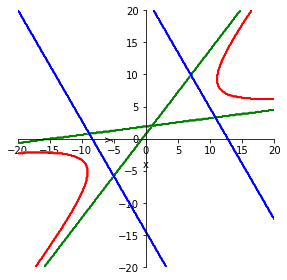

In [8]:
eq = Hyp1.equation(equation=True, _slope = tan(pi/6))
dict_free = {str(a): a for a in eq.free_symbols}

asymp = Hyp1.asymptote(equation = True, tg_a = tan(pi/6))
dir = Hyp1.directrix(tg_a = tan(pi/6), equation = True)

p = plot_implicit(eq, (dict_free['x'], -20, 20), (dict_free['y'], -20, 20),
                  line_color='r', aspect_ratio=(1, 1), show=False, adaptive=False)

p.extend(plot_implicit(asymp[0], (dict_free['x'], -20, 20), (dict_free['y'], -20, 20),
                  line_color='g', aspect_ratio=(1, 1), show=False, adaptive=False))
p.extend(plot_implicit(asymp[1], (dict_free['x'], -20, 20), (dict_free['y'], -20, 20),
                  line_color='g', aspect_ratio=(1, 1), show=False, adaptive=False))

p.extend(plot_implicit(dir[0], (dict_free['x'], -20, 20), (dict_free['y'], -20, 20),
                  line_color='b', aspect_ratio=(1, 1), show=False, adaptive=False))
p.extend(plot_implicit(dir[1], (dict_free['x'], -20, 20), (dict_free['y'], -20, 20),
                  line_color='b', aspect_ratio=(1, 1), show=False, adaptive=False))

p.show()

###  Индивидуальное задание
Определить гиперболу с центром в $(X, Y)$, полуосями $a$ и $b$.  Вывести на экран эксцентриситет, фокусное расстояние, фокусы (с координатами), periapsis, уравнение гиперболы, уравнения асимптот и директрис. 

Изобразить гиперболу, повернутую на $\alpha$ градусов против часовой стрелки относительно ее центра, соответствующие асимптоты и директрисы. Вывести на экран уравнение повернутой гиперболы.

Центр $Point2D\left(3, 4\right)$, вертикальная полуось $5 \sqrt{6} / 4$, эксцентриситет $7 / 5$, угол поворота $\pi / 4$, по часовой стрелке.


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

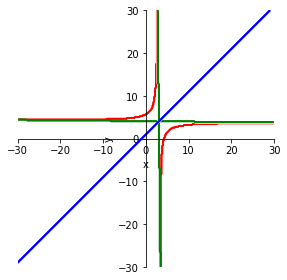

In [9]:
Hyp = Hyperbola(Point(3, 4), vradius=5*sqrt(6)/4, eccentricity=S(7)/5)
ang = -pi/4

props = {'eccentricity': Hyp.eccentricity,'focus\_distance': Hyp.focus_distance, 'foci': Hyp.foci, 
         'periapsis': Hyp.periapsis, 'equation': Hyp.equation(equation=True),
         'asymptote': Hyp.asymptote(equation = True), 'directrix': Hyp.directrix(equation = True)}

display(*[Latex(f'{key} = {latex(props[key])}') for key in props.keys()])

eq = Hyp.equation(equation=True, _slope = tan(ang))
dict_free = {str(a): a for a in eq.free_symbols}

asymp = Hyp.asymptote(equation = True, tg_a = tan(ang))
dir = Hyp.directrix(tg_a = tan(ang), equation = True)

p = plot_implicit(eq, (dict_free['x'], -30, 30), (dict_free['y'], -30, 30),
                  line_color='r', aspect_ratio=(1, 1), show=False, adaptive=False)

p.extend(plot_implicit(asymp[0], (dict_free['x'], -30, 30), (dict_free['y'], -30, 30),
                  line_color='g', aspect_ratio=(1, 1), show=False, adaptive=False))
p.extend(plot_implicit(asymp[1], (dict_free['x'], -30, 30), (dict_free['y'], -30, 30),
                  line_color='g', aspect_ratio=(1, 1), show=False, adaptive=False))

p.extend(plot_implicit(dir[0], (dict_free['x'], -30, 30), (dict_free['y'], -30, 30),
                  line_color='b', aspect_ratio=(1, 1), show=False, adaptive=False))

p.extend(plot_implicit(dir[1], (dict_free['x'], -30, 30), (dict_free['y'], -30, 30),
                  line_color='b', aspect_ratio=(1, 1), show=False, adaptive=False))

p.show()

Хорасанджян Левон, вариант №157